# Window Sliding Processing

Idea: use a sliding window going through all tuples of the same train, divide into individual traject using the timestamps, and compare the previous tuples of the sliding window to decide on different flag to add to the tuple:
- if the train is stopped at the given moment in time of the tuple.
  - use the speed of the train, and if it is below a certain threshold, then it is stopped.
  - use the distance between the previous tuple and the current tuple, and if it is below a certain threshold, then it is stopped.
  - use external information, such as the positions stations in Belgium
  - could want to create a model that defines waiting points in the system
  - note: might be useless, since we are using intervals more than moments in time

In [2]:
import numpy as np
import pandas as pandas
import pandas as pd

In [4]:
# index is the first row
df = pandas.read_csv('../backup/ar41_for_ulb.csv', sep=";", index_col=0)

df.head()

mapped_veh_id       timestamps_UTC        lat       lon  \
0          181.0  2023-08-01 03:44:12  50.769818  3.872114   
1          143.0  2023-08-01 06:36:29  51.039993  3.693429   
2          183.0  2023-08-24 06:53:54  50.742203  3.602035   
3          177.0  2023-08-01 13:53:38  50.930914  5.327132   
4          143.0  2023-08-24 07:02:30  51.180773  3.575259   

   RS_E_InAirTemp_PC1  RS_E_InAirTemp_PC2  RS_E_OilPress_PC1  \
0                27.0                23.0              255.0   
1                33.0                32.0              272.0   
2                31.0                33.0              234.0   
3                35.0                38.0              220.0   
4                41.0                34.0              227.0   

   RS_E_OilPress_PC2  RS_E_RPM_PC1  RS_E_RPM_PC2  RS_E_WatTemp_PC1  \
0              238.0         794.0         801.0              83.0   
1              324.0         802.0         804.0              78.0   
2              182.0         799.0         802.0              82.0   
3              244.0         794.0         801.0              77.0   
4              282.0         806.0         800.0              85.0   

   RS_E_WatTemp_PC2  RS_T_OilTemp_PC1  RS_T_OilTemp_PC2  
0              81.0              76.0              77.0  
1              78.0              73.0              74.0  
2              82.0              85.0              87.0  
3              81.0              78.0              82.0  
4              78.0              82.0              79.0

## Pre-processing

### Data Cleaning

In [5]:
# We have about 3 million tuples
print("Number of tuples:", len(df))

# We have about 100 different trains
train_ids = df['mapped_veh_id'].unique()
print("Number of unique trains:", len(train_ids))

Number of tuples: 17679273
Number of unique trains: 92


Number of train with N/A values: 92


<BarContainer object of 92 artists>

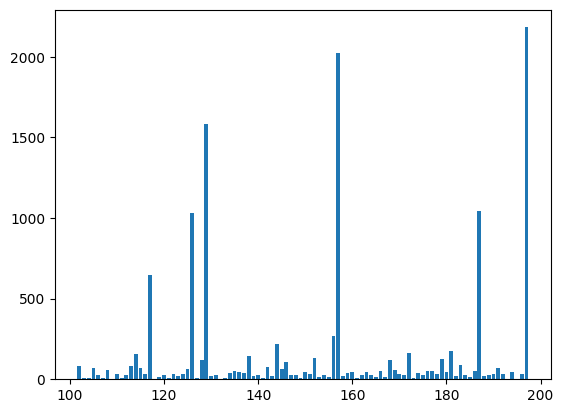

In [19]:
import matplotlib.pyplot as plt

# Recover all rows with N/A values
df_NA = df[df.isna().any(axis=1)]

print("Number of train with N/A values:", len(df_NA['mapped_veh_id'].unique()))

# Plot a histogram showing frequency of N/A values for each train
train_ids = df_NA['mapped_veh_id'].unique()

# Create a list of the number of N/A values for each train
train_NA = []
for train_id in train_ids:
    train_NA.append(len(df_NA[df_NA['mapped_veh_id'] == train_id]))

# Plot the bar plot
plt.bar(train_ids, train_NA)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, 'mapped_veh_id'),
  Text(1, 0, 'timestamps_UTC'),
  Text(2, 0, 'lat'),
  Text(3, 0, 'lon'),
  Text(4, 0, 'RS_E_InAirTemp_PC1'),
  Text(5, 0, 'RS_E_InAirTemp_PC2'),
  Text(6, 0, 'RS_E_OilPress_PC1'),
  Text(7, 0, 'RS_E_OilPress_PC2'),
  Text(8, 0, 'RS_E_RPM_PC1'),
  Text(9, 0, 'RS_E_RPM_PC2'),
  Text(10, 0, 'RS_E_WatTemp_PC1'),
  Text(11, 0, 'RS_E_WatTemp_PC2'),
  Text(12, 0, 'RS_T_OilTemp_PC1'),
  Text(13, 0, 'RS_T_OilTemp_PC2')])

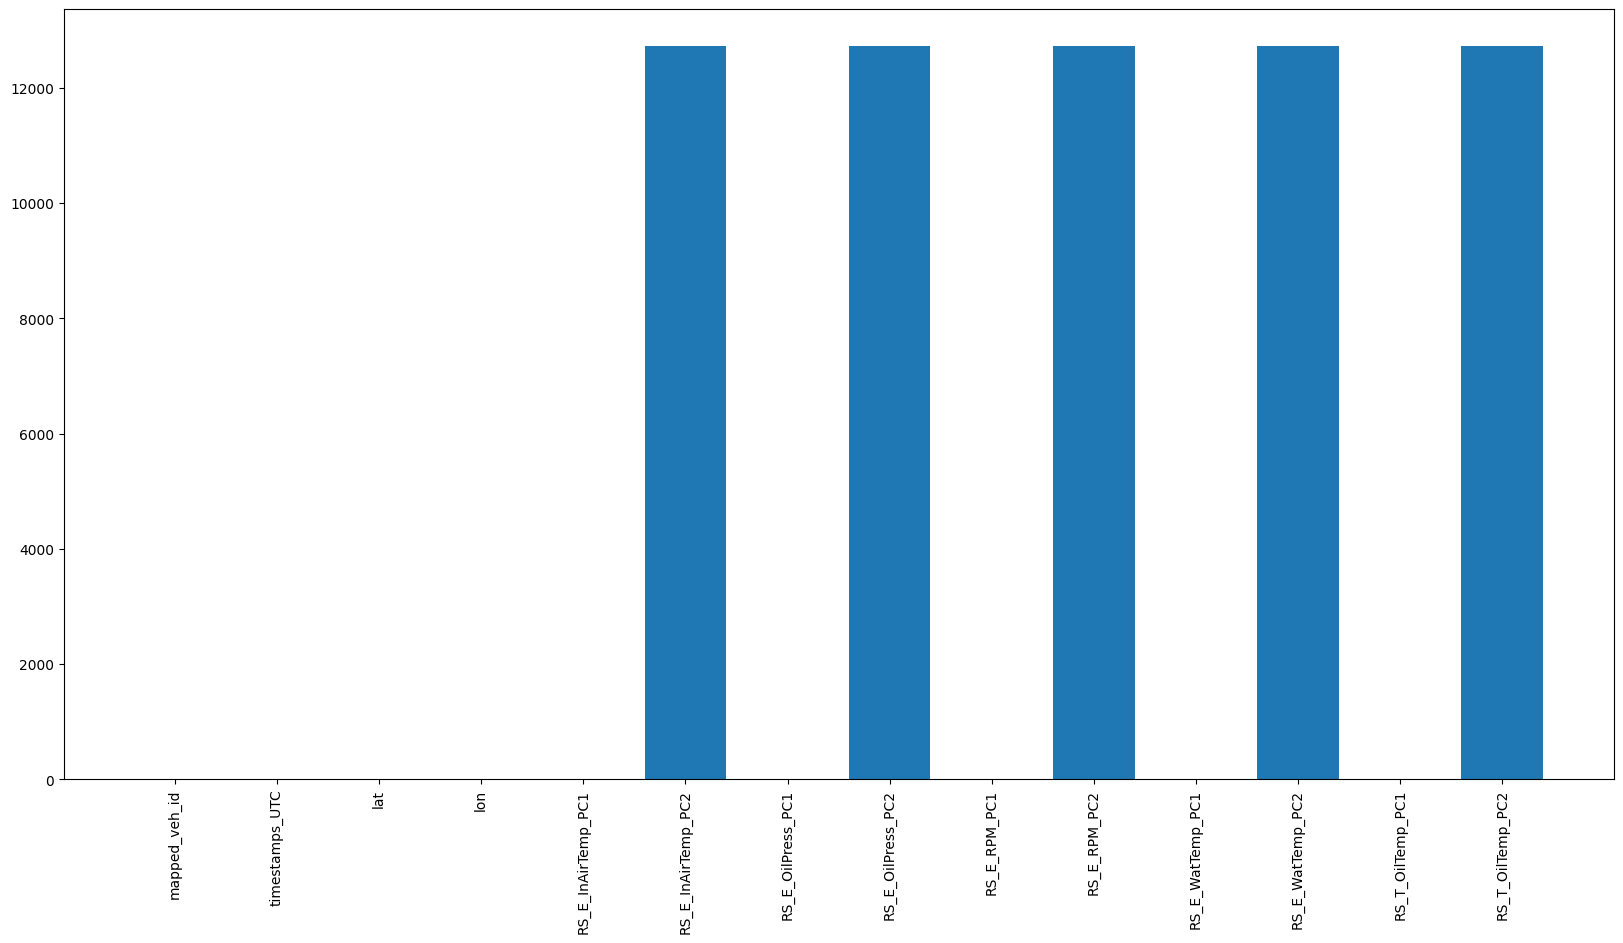

In [25]:
# Plot the frequency of N/A for each column
# Create a list of the number of N/A values for each column
column_NA = []

for column in df.columns:
    column_NA.append(len(df[df[column].isna()]))

# Plot the bar plot
plt.figure(figsize=(20, 10))
plt.bar(df.columns, column_NA)

# put labels vertically
plt.xticks(rotation='vertical')

In [23]:
# Plot N/A on a map
import folium

# Create a map, centered on Belgium, don't allow to zoom
m = folium.Map(
    location=[50.503887, 4.469936],
    # Easily readable tiles
    tiles='cartodbpositron',
    zoom_start=8,
    zoom_control=False,
    scrollWheelZoom=False,
    dragging=False
)

# Add points to the map
for idx, row in df_NA.iterrows():
    folium.CircleMarker([row['lat'], row['lon']], radius=1, color='red').add_to(m)

# Display the map
m

In [17]:
# Recover all rows with N/A values
df_NA = df[df.isna().any(axis=1)]

print("Number of train with N/A values:", len(df_NA['mapped_veh_id'].unique()))

# Remove all N/A values
df_no_NA = df.dropna()
print("Number of tuples after removing N/A values:", len(df_no_NA))
print("Number of tuples removed:", len(df) - len(df_no_NA))
print("Number of unique trains after removing N/A values:", len(df_no_NA['mapped_veh_id'].unique()))

df_NA.drop(['mapped_veh_id', 'lat', 'lon', 'timestamps_UTC'], axis=1).describe()

Number of train with N/A values: 92
Number of tuples after removing N/A values: 17666547
Number of tuples removed: 12726
Number of unique trains after removing N/A values: 92


RS_E_InAirTemp_PC1  RS_E_InAirTemp_PC2  RS_E_OilPress_PC1  \
count        12726.000000                 0.0        12726.00000   
mean            24.166582                 NaN          296.49383   
std             15.816148                 NaN          174.62280   
min              0.000000                 NaN            0.00000   
25%             10.000000                 NaN          217.00000   
50%             26.000000                 NaN          269.00000   
75%             38.000000                 NaN          400.00000   
max             83.000000                 NaN          690.00000   

       RS_E_OilPress_PC2  RS_E_RPM_PC1  RS_E_RPM_PC2  RS_E_WatTemp_PC1  \
count                0.0  12726.000000           0.0      12726.000000   
mean                 NaN    719.684064           NaN         60.485469   
std                  NaN    332.758620           NaN         28.571293   
min                  NaN      0.000000           NaN          0.000000   
25%                  NaN    796.000000           NaN         28.000000   
50%                  NaN    799.000000           NaN         77.000000   
75%                  NaN    802.000000           NaN         82.000000   
max                  NaN   2290.000000           NaN         97.000000   

       RS_E_WatTemp_PC2  RS_T_OilTemp_PC1  RS_T_OilTemp_PC2  
count               0.0      12726.000000               0.0  
mean                NaN         60.754926               NaN  
std                 NaN         29.401869               NaN  
min                 NaN          0.000000               NaN  
25%                 NaN         38.000000               NaN  
50%                 NaN         74.000000               NaN  
75%                 NaN         84.000000               NaN  
max                 NaN        103.500000               NaN

We can see that the N/A values are only present in the PC2 columns. And when there is NaN value, then all PC2 related columns of the given row are NaN.

This means that we could either:
- remove all the rows with NaN values, because we do not have the linking of the two parts of the train
- or use those rows only for PC1 specific analysis

But overall, most of those NaN values come with columns that have no information on PC2, so we can remove them.

In [ ]:
# Describe all columns but lat, lon, and timestamps_UTC
df.drop(['mapped_veh_id', 'lat', 'lon', 'timestamps_UTC'], axis=1).describe()

All the temperatures should be compared to typical seasonal temperature to see if there are any outliers.

Note that sensors can be faulty, and that the temperature can be wrong. We could therefore not remove the outliers, but rather use them to create a flag that indicates that the temperature is wrong to train a predictive model, that uses the temperature of the other fluids and the seasonal temperatures to determine the faultiness.

In [ ]:
df[['lat', 'lon']].describe()

We can see that all the positions in the data are in the following geobox (49.38359,3.574995) to (51.30288,5.573039), which approximately corresponds to Belgium. This is a good sign, since we are only interested in the data of Belgium, there are no completely off the map outliers.

In [ ]:
# plot the rectangle on a map
import folium

# Create a map, centered on Belgium, don't allow to zoom
m = folium.Map(
    location=[50.503887, 4.469936],
    # Easily readable tiles
    tiles='cartodbpositron',
    zoom_start=8,
    zoom_control=False,
    scrollWheelZoom=False,
    dragging=False
)

# Add points to the map
# chose some random points of the data
points = np.random.choice(len(df), 100000, replace=False)

for idx, row in df.iloc[points].iterrows():
    folium.CircleMarker([row['lat'], row['lon']], radius=1, color='red').add_to(m)

# Display the map
m
# m.show_in_browser()

The random point chosen in the dataset showcase the fact that the data is only in Belgium.

The only outliers we could have are therefore the data points that make no sense in terms of positions compared to the previous data point of the same train at about the same time. Can only be found by using a time window that compares the positions of the train at different moments in time.


## Study Time Intervals

### Preliminary Study

In [ ]:
# Make the timestamp a datetime object instead of a string
df['timestamps_UTC'] = pandas.to_datetime(df['timestamps_UTC'])

# We have data from 2022-08-22 14:48:25 to 2023-09-13 21:51:57
print("Data ranges from", df['timestamps_UTC'].min(), "to", df['timestamps_UTC'].max())
print("Data spans:", df['timestamps_UTC'].max() - df['timestamps_UTC'].min())

# Number of tuples per train (avg: 192.000)
train_tuples = df.groupby('mapped_veh_id').size()
print("Tuples per unique train:\n" + str(train_tuples.describe()))

# Number of tuples per train per day (avg: 1.100)
df_day = df.copy()
df_day['timestamps_UTC'] = df_day['timestamps_UTC'].dt.date
train_tuples_per_day = df_day.groupby(['mapped_veh_id', 'timestamps_UTC']).size()
print("\nTuples per unique train per day:\n" + str(train_tuples_per_day.describe()))

# Describe the time between the tuples of a given train for a given day
df_range = df[['mapped_veh_id', 'timestamps_UTC']].copy()
# Sort the tuples by time
df_range = df_range.sort_values(by=['mapped_veh_id', 'timestamps_UTC'])
# Compute the time difference between each tuple of a given train
df_range['time_difference'] = df_range.groupby(['mapped_veh_id'])['timestamps_UTC'].diff().dropna()
df_range['time_difference'].describe()

Conclusions:
1. Notice that some trains do not have that many data tuples, and that the average is 190.000 tuples per train.
2. Notice also that some trains do not have data for every day, and that the average is 1.100 tuples per train per day.

Seeing how certain train have close to zero information per day, let's assume that the train is not running on those days. A small amount of data is a risk for the model, since it might not be able to learn anything from it. We will therefore remove all the days when the train has less than a given amount of tuples.

We should therefore define two thresholds:
- The minimum amount of tuples per train per day
- The minimum amount of tuples per train

We shall then remove the tuples that do not respect these thresholds.

### Estimate distance and speed between tuples

Using the timestamps between each tuple of a given train, we can estimate the distance and speed between each tuple of a given train.

In [ ]:
# vectorized haversine function
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.
    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2 - lat1) / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin((lon2 - lon1) / 2.0) ** 2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))  # return the value in km since the earth_radius is in km

In [ ]:
# TODO: add the different columns that can be estimated from the data
#   - speed in the interval
#   - distance from last point

# if the processed.csv file already exists, then load it
try:
    processed_df = pandas.read_csv('../assets/processed.csv', sep=";")
    processed_df['timestamps_UTC'] = pandas.to_datetime(processed_df['timestamps_UTC'])
except FileNotFoundError:
    print("File not found, creating it...")

    processed_df = df.copy()

    processed_df = processed_df.dropna()

    # Compute the time interval between each tuple of a given train
    processed_df = processed_df.sort_values(by=['mapped_veh_id', 'timestamps_UTC'])
    processed_df['time_difference'] = processed_df.groupby(['mapped_veh_id'])['timestamps_UTC'].diff().dropna()

    # Replace N/A values with 0 seconds
    processed_df['time_difference'] = processed_df['time_difference'].fillna(pandas.Timedelta(seconds=0))

    # Compute the relative distance and average speed between each tuple for each train separately
    for vehicle in processed_df['mapped_veh_id'].unique():
        # Get the index of the tuples of the given train
        vehicle_idx = processed_df[processed_df['mapped_veh_id'] == vehicle].index

        # Compute the distance between each tuple of the given train
        processed_df.loc[vehicle_idx, 'distance'] = haversine(
            processed_df.loc[vehicle_idx, 'lat'].shift(),
            processed_df.loc[vehicle_idx, 'lon'].shift(),
            processed_df.loc[vehicle_idx, 'lat'],
            processed_df.loc[vehicle_idx, 'lon']
        ) * 1000  # multiplied by 1000 to have it in meters instead of kilometers
        # Replace the first distance with 0
        processed_df.loc[vehicle_idx[0], 'distance'] = 0

        # Compute the speed between each tuple of the given train
        processed_df.loc[vehicle_idx, 'speed'] = processed_df.loc[vehicle_idx, 'distance'] / processed_df.loc[
            vehicle_idx, 'time_difference'].dt.total_seconds()  # in m/s, should
        # Replace the first speed with 0
        processed_df.loc[vehicle_idx[0], 'speed'] = 0

    # Store the processed dataframe
    processed_df.to_csv('../assets/processed.csv', sep=";", index=False)

processed_df

In [ ]:
# Create a csv file for each train in the in the dataset
df = pd.read_csv('../assets/processed.csv', sep=';')

# Group by train
grouped = df.groupby('mapped_veh_id')

# Iterate over each train
for train_id, train_df in grouped:
    # Save the train in a csv file
    train_df.to_csv(f'../assets/trains/{int(train_id)}.csv', sep=';', index=False)

### Study of the sensors

Define analytical rules to determine if a sensor is faulty or not.

#### Step 1: Study the distribution of the sensors

In [ ]:
# Describe the temperature of the different fluids
print(processed_df[['RS_E_InAirTemp_PC1', 'RS_E_InAirTemp_PC2']].describe())

print(processed_df[['RS_T_OilTemp_PC1', 'RS_T_OilTemp_PC2']].describe())

print(processed_df[['RS_E_WatTemp_PC1', 'RS_E_WatTemp_PC2']].describe())

# Describe the pressure of the different fluids
print(processed_df[['RS_E_OilPress_PC1', 'RS_E_OilPress_PC2']].describe())

In [ ]:
# For each vehicle id, plot the evolution RS_E_RPM_PC1
# For each vehicle id, plot the evolution RS_E_RPM_PC2
for x, (vehicle, group) in enumerate(processed_df.groupby("mapped_veh_id")):
    slice = group[50:100]
    # slice.plot(x="timestamps_UTC", y=["RS_E_OilPress_PC1", "RS_E_OilPress_PC2"], ylim=[0, 500], title="Vehicle {}".format(vehicle))

# print(processed_df[processed_df['mapped_veh_id'] == 125][['RS_E_RPM_PC1', 'RS_E_RPM_PC2']].iloc[50:100])


In [ ]:
# ENGINE RPM
# From the data, we see that the engine RPM is always between 0 and 2000.
RPM = [0, 2000]
# We also see that the nominal value is around 800.
# Using this information, we can consider the running RPM range of the engines to be between 700 and 900 RPM.
RPM_NOMINAL = [0, 2400]

# outside_range =  processed_df[((processed_df['RS_E_RPM_PC1'] < RPM_NOMINAL[0]) | (processed_df['RS_E_RPM_PC1'] > RPM_NOMINAL[1])) & ((processed_df['RS_E_RPM_PC1'] != 0) | (processed_df['RS_E_RPM_PC1'] != 0))]
# print(len(outside_range))
#
# outside_range = processed_df[((processed_df['RS_E_RPM_PC2'] < RPM_NOMINAL[0]) | (processed_df['RS_E_RPM_PC2'] > RPM_NOMINAL[1])) & ((processed_df['RS_E_RPM_PC2'] != 0) | (processed_df['RS_E_RPM_PC2'] != 0))]
# print(len(outside_range))
# print(outside_range[['RS_E_RPM_PC1', 'RS_E_RPM_PC2']])


# PRESSURE
# If the pressure is below 0, then the sensor is faulty
# Note: pressure drops to zero only if engine is stopped, so if both sensors are 0, then it may have sense
#  to assume that the engine is stopped, and therefore that the pressure is 0. But, if only one sensor is 0,
#  then ont of them is probably faulty.
OIL_PRESSURE = [0, 690]  # min and max value in the data

# TEMPERATURE
# All temperatures must be in a functional range,
AIR = [0, 65]
WATER = [0, 100]
OIL = [0, 115]
# The maximum acceptable temperatures are for the:
#   - air: 65°C,
#   - water: 100°C,
#   - oil: 115°C.
# Above those thresholds the engines are stopped automatically to avoid damage.

# AIR TEMPERATURE
# Air input from outside, so it is normal to have a low temperature in winter by example
# Detection of low temperature can be used to detect a faulty sensor, typically, if both detect low
# temperature, then it is probably normal, since they take it from outside the train engine,
# but if only one detects low temperature, then one of them is probably faulty,
# most certainly the one sending zero, but could also be a difference that make no sense and no zero value.

# OIL TEMPERATURE and WATER TEMPERATURE
# Both are in closed loop

## Add Weather Data

In [ ]:
import geopandas as gpd
from shapely.geometry import Point

In [ ]:
city_locations = {
    "hasselt": [50.930965, 5.338333],
    "brussels": [50.85045, 4.34878],
    "antwerp": [51.21989, 4.40346],
    "ghent": [51.05, 3.71667],
    "charleroi": [50.41136, 4.44448],
}

cities_df = pd.DataFrame(
    data={
        "city": [key for key in city_locations.keys()],
        "lat": [city_locations[key][0] for key in city_locations.keys()],
        "lon": [city_locations[key][1] for key in city_locations.keys()]
    }
)

In [ ]:
# Create a GeoDataFrame for your data tuples
# Example: Assuming you have a DataFrame 'data_df' with columns 'latitude' and 'longitude'
data_geometry = [Point(xy) for xy in zip(processed_df['lat'], processed_df['lon'])]
data_gdf = gpd.GeoDataFrame(processed_df, geometry=data_geometry, crs="EPSG:4326")

# Create a GeoDataFrame for cities with their locations
# Example: Assuming you have a DataFrame 'cities_df' with columns 'city_name', 'latitude', and 'longitude'
cities_geometry = [Point(xy) for xy in zip(cities_df['lat'], cities_df['lon'])]
cities_gdf = gpd.GeoDataFrame(cities_df, geometry=cities_geometry, crs="EPSG:4326")

In [ ]:
# Perform a spatial join to find the closest city for each data tuple
# 'op' parameter defines the spatial relationship (in this case, it finds the nearest city)
result_gdf = gpd.sjoin_nearest(data_gdf, cities_gdf, how="left")

In [ ]:
# Display or use the result DataFrame as needed
print(result_gdf.head())
result_df = result_gdf[[processed_df.colnames, "city"]]